<a href="https://colab.research.google.com/github/zeyadhabib/Show-Attend-and-Tell-model-/blob/main/Pattern_Project_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download caption annotation files
annotation_folder = '/content/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  '''
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  
  annotation_file = '/content/annotations/captions_train2014.json'
  os.remove(annotation_zip)
  '''
# Download image files
annotation_file = '/content/annotations/captions_train2014.json'
image_folder = '/content/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  '''
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  '''
  PATH = image_folder
  #os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [ ]:
class CNN_Encoder(tf.keras.Model):

  def __init__(self, embedding_dim, CNN_type="InceptionV3"):
    super(CNN_Encoder, self).__init__()
    if CNN_type is "InceptionV3":
      image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
      self.image_shape = (299, 299)
      self.attention_shape = 64
      self.features_shape = 2048

    elif CNN_type is "MobileNetV2":
      image_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
      self.image_shape = (224, 224)
      self.attention_shape = 49
      self.features_shape = 1280

    elif CNN_type is "vgg16":
      image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
      self.image_shape = (224, 224)
      self.attention_shape = 49
      self.features_shape = 512

    elif CNN_type is "ResNet50V2":
      image_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
      self.image_shape = (224, 224)
      self.attention_shape = 49
      self.features_shape = 2048

    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output
    self.CNN_type = CNN_type
    self.CNN = tf.keras.Model(new_input, hidden_layer)
    self.CNN.trainable = False
    self.dense_1 = tf.keras.layers.Dense(embedding_dim, activation='relu')

  def call(self, inputs):
    x = self.CNN(inputs)
    x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
    x = self.dense_1(x)
    return x

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden[0])

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state_h, state_c = self.lstm(x)
    state = [state_h, state_c]

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Load the numpy files
def map_func(img_path, cap, shape, CNN_type_call):

  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, shape)

  CNN_type = CNN_type_call.decode('utf-8')
  if CNN_type == 'InceptionV3':
    img = tf.keras.applications.inception_v3.preprocess_input(img)
      
  elif CNN_type == 'MobileNetV2':
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

  elif CNN_type == 'vgg16':
    img = tf.keras.applications.vgg16.preprocess_input(img)

  elif CNN_type == 'ResNet50V2':
    img = tf.keras.applications.resnet_v2.preprocess_input(img)

  return img, cap

In [ ]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
'''
num_examples = 60000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
'''

# Choose the top 5000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    #train_captions,
                                                                    test_size=0.2,
                                                                    random_state=0)



In [ ]:
embedding_dim = 256
units = 512
vocab_size = top_k + 1

In [ ]:
encoder = CNN_Encoder(embedding_dim, CNN_type="ResNet50V2")
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = encoder.features_shape
attention_features_shape = encoder.attention_shape

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, 
                                                             [item1, item2,
                                                              encoder.image_shape,
                                                              encoder.CNN_type],
                                                             [tf.float32, tf.int32]))

# Shuffle and batch

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "/content/drive/My Drive/Pattern/checkpoints/train2/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

In [ ]:
'''
%cd /content/drive/'My Drive'/Pattern/checkpoints/
! rm -r train2
%cd ~
! ls
'''

"\n%cd /content/drive/'My Drive'/Pattern/checkpoints/\n! rm -r train2\n%cd ~\n! ls\n"

In [ ]:
start_epoch = 0

if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)


In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  # print('dec input before expand dims', )
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  # dec_input = Tensor() shape == (batch_size, 1)
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]): # loop till max possible caption length
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden) # predict one word
          
          loss += loss_function(target[:, i], predictions) # calculate word loss
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
          
  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    ckpt_manager.save()
    filename = "from_" + str(start_epoch) + "to" + str(epoch) + str(".npy")
    np.save("/content/drive/My Drive/Pattern/checkpoints/" + filename, np.array(loss_plot))
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

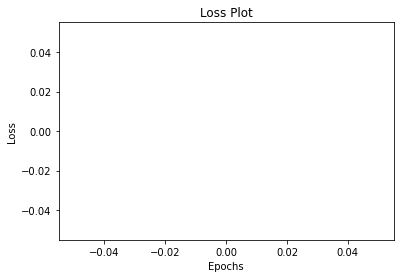

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, encoder.image_shape)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, encoder.attention_shape))
    hidden = decoder.reset_state(batch_size=1)

    #temp_input = tf.expand_dims(load_image(image)[0], 0)
    #img_tensor_val = image_features_extract_model(temp_input)
    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(tf.expand_dims(load_image(image)[0], 0))

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (7, 7))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a towel rests on the edge of a tub in an old fashioned looking bathroom <end>
Prediction Caption: a large bathroom that has wooden walls and a bathtub near a modern bathtub <end>


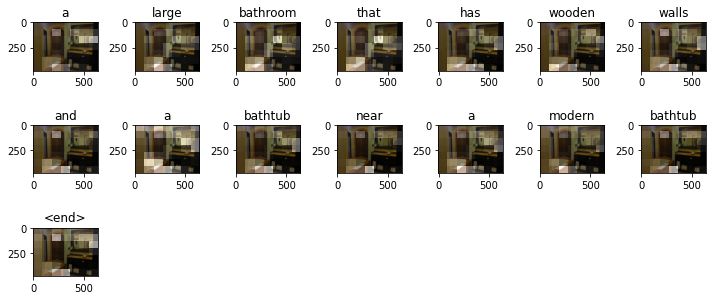

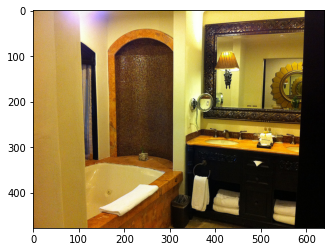

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
temp_image = np.array(Image.open(image))
img = plt.imshow(temp_image)


Prediction Caption: a little boy on ocean wave all of dark blue waves <end>


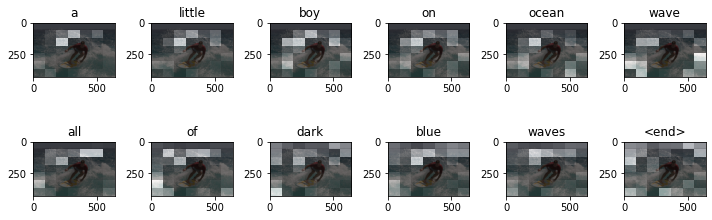

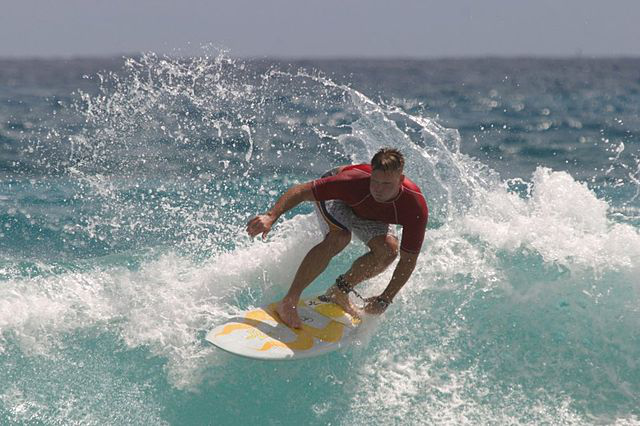

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
!pip install --quiet bert_score
from bert_score import score

In [ ]:
LEN = len(img_name_val)
pred_captions = []
for rid in range(LEN):
    pred_captions.append(' '.join(evaluate(img_name_val[rid])[0]))
    if rid % 100 == 0:
        print(rid)

In [ ]:
pred_path = "/content/drive/My Drive/Pattern/predictions.txt"
f = open(pred_path, "w")
for line in pred_captions:
    print(line, file=f)
f.close()

In [ ]:
real_captions = [' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]]) for rid in range(LEN)]
real_path = "/content/drive/My Drive/Pattern/real_cap.txt"
f = open(real_path, "w")
for line in real_captions:
    print(line, file=f)
f.close()